# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

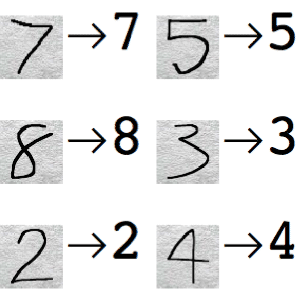

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

11490434/11490434 [==============================] - 2s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


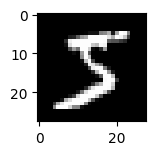

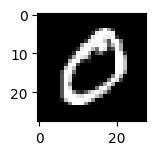

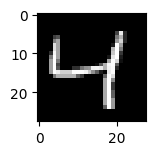

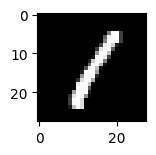

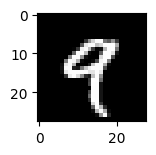

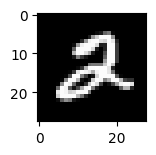

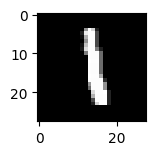

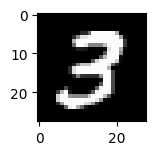

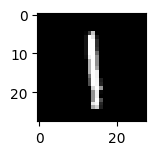

In [2]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

###Xem thử các mẫu ảnh thì hình dáng chữ như thế nào

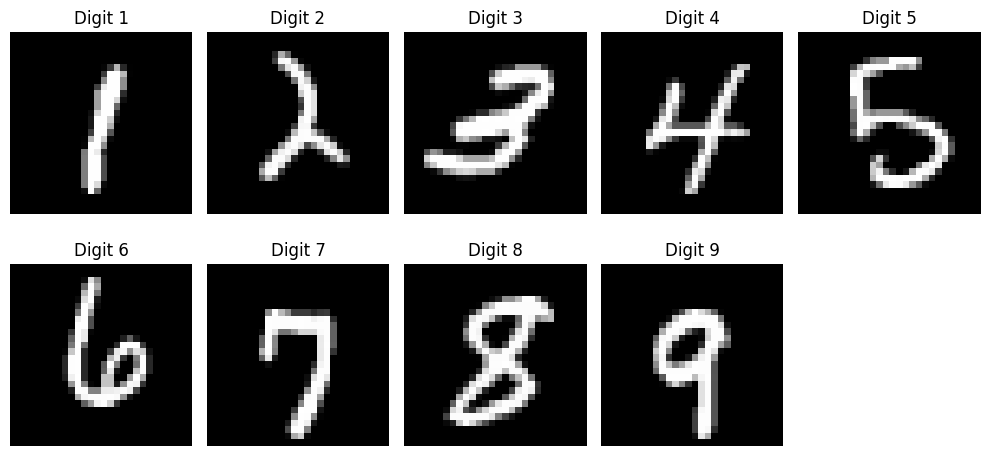

In [ ]:
import numpy as np

# Create a list to store the indices of one example of each digit
digit_indices = []

# Randomly select one example of each digit from the training set
for i in range(1, 10):  # Digits 1 through 9
    # Find indices of images with label i
    indices = np.where(trainy == i)[0]
    # Randomly select one index
    random_index = np.random.choice(indices)
    # Append the selected index to the list
    digit_indices.append(random_index)

# Plot one example of each digit
plt.figure(figsize=(10, 5))
for i, index in enumerate(digit_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(trainX[index], cmap='gray')
    plt.title(f"Digit {trainy[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


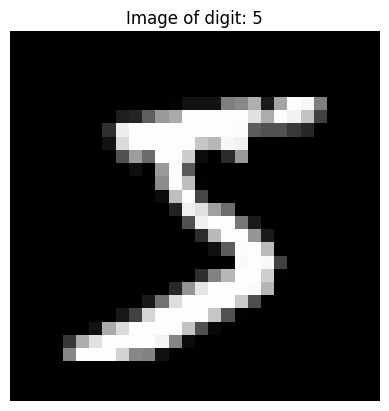

In [3]:
import matplotlib.pyplot as plt

# Assuming trainX and trainY are already loaded and preprocessed

# Choose an index to view
index = 0  # You can choose any index within the range of your dataset size

# Display the image from trainX
plt.imshow(trainX[index], cmap='gray')
plt.title(f"Image of digit: {trainy[index]}")  # Display the corresponding label from trainY
plt.axis('off')  # Turn off axis
plt.show()

In [4]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [5]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY


## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [6]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [7]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [8]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=6):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [9]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [10]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [11]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.680
> 98.760
> 98.760
> 98.710
> 98.800
> 98.690


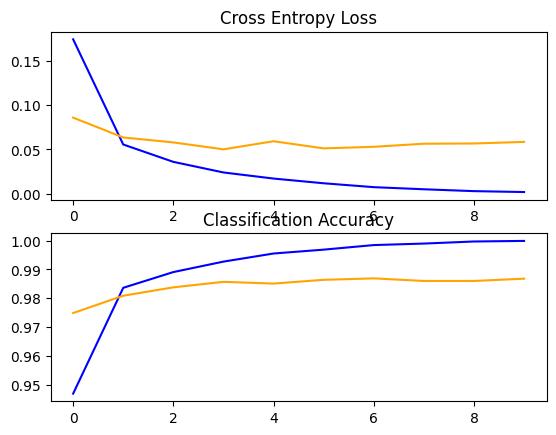

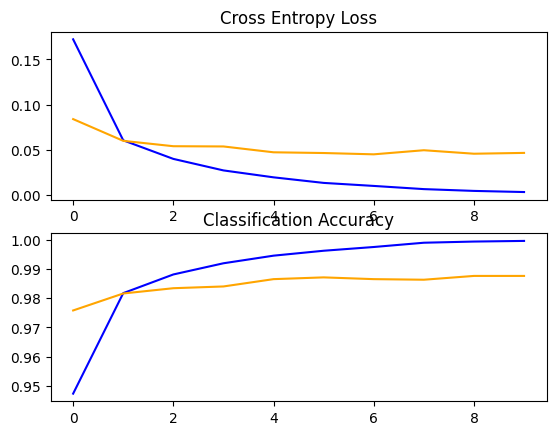

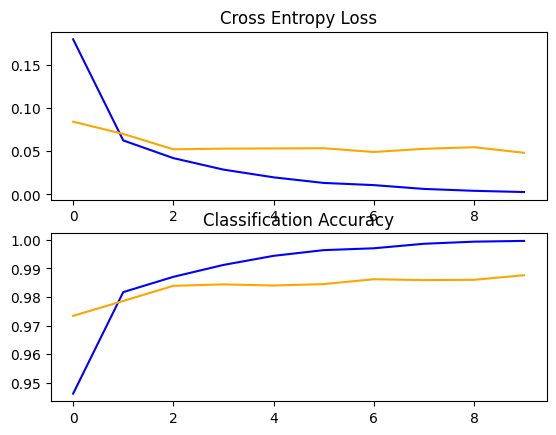

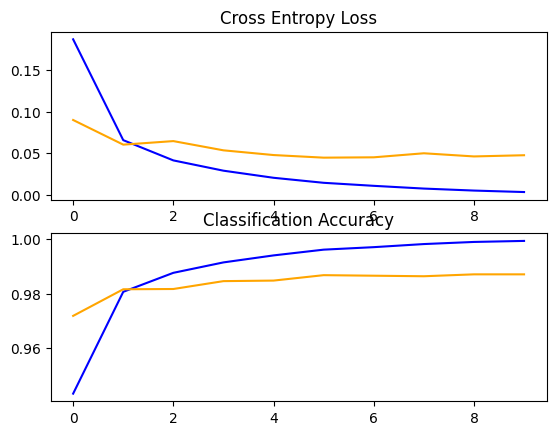

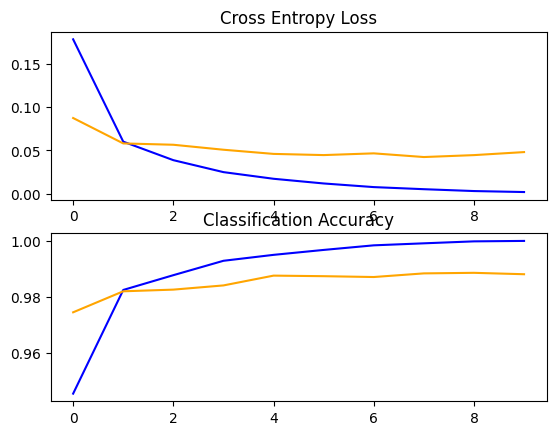

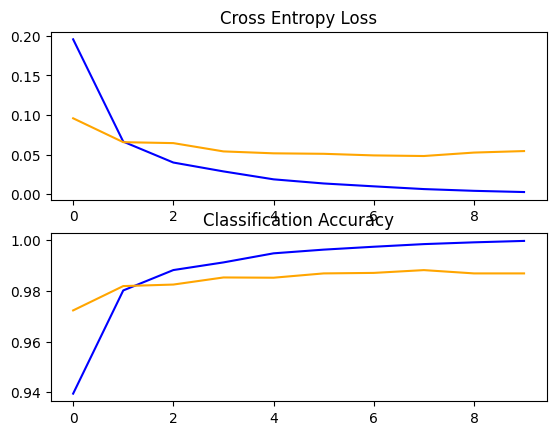

Accuracy: mean=98.733 std=0.043, n=6


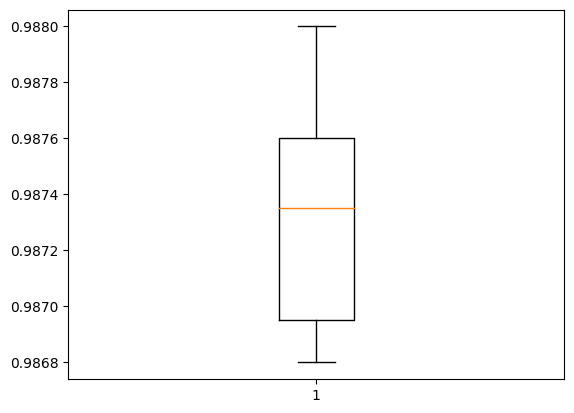

In [12]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [13]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

run_test_harness2()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate Final Model

In [ ]:
run_test_harness2()

## Make Prediction

In [16]:
import cv2
import numpy as np

def load_image(filename, alpha=0.85, beta=2, threshold=130, dilation_kernel_size=3):
    # Load the image
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Apply thresholding to convert to black and white
    _, img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

    # Invert the pixels
    img = cv2.bitwise_not(img)

    # Dilate the image to make area near white pixels also white
    kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)

    # Resize the image to target size
    img = cv2.resize(img, (28, 28))

    # Reshape into a single sample with 1 channel
    img = img.reshape(-1, 28, 28, 1)

    # Prepare pixel data
    img = img.astype('float32')
    img = img / 255.0

    return img


# for i in range(60):
#   img = load_image(f"real_test{(i//10)+1}/{i%10}.jpg")

# # Reshape the image to remove the batch dimension (if present)
#   img = img.reshape(28, 28)

#   # Display the image
#   plt.imshow(img, cmap='gray')  # Display in grayscale
#   plt.title(f"real_test{(i//10)+1}/{i%10}.jpg")
#   plt.axis('off')  # Turn off axis
#   plt.show()

In [15]:
!unzip 21522458.zip

Archive:  21522458.zip
   creating: data/
   creating: data/21522458/
   creating: data/21522458/0/
  inflating: data/21522458/0/0.0.jpg  
  inflating: data/21522458/0/0.1.jpg  
  inflating: data/21522458/0/0.3.jpg  
   creating: data/21522458/1/
  inflating: data/21522458/1/1.1.jpg  
  inflating: data/21522458/1/1.2.jpg  
  inflating: data/21522458/1/1.3.jpg  
   creating: data/21522458/2/
  inflating: data/21522458/2/2.1.jpg  
  inflating: data/21522458/2/2.2.jpg  
  inflating: data/21522458/2/2.3.jpg  
   creating: data/21522458/3/
  inflating: data/21522458/3/3.1.jpg  
  inflating: data/21522458/3/3.2.jpg  
  inflating: data/21522458/3/3.3.jpg  
   creating: data/21522458/4/
  inflating: data/21522458/4/4.1.jpg  
  inflating: data/21522458/4/4.2.jpg  
  inflating: data/21522458/4/4.3.jpg  
   creating: data/21522458/5/
  inflating: data/21522458/5/5.1.jpg  
  inflating: data/21522458/5/5.2.jpg  
  inflating: data/21522458/5/5.3.jpg  
   creating: data/21522458/6/
  inflating: data/

###Evaluation for 21522458 - Nguyễn Phạm Thanh Phong 's input images

In [34]:
total_img = 3*10*2

In [53]:
# load an image and predict the class

def execute_predictions(prev_paths):
  correct_predictions = 0
  total_digits = 10
  total_files_per_digit = 3
  for prev_path in prev_paths:
    for current_digit in range(total_digits):
      for file_num in range(total_files_per_digit):
        img_path = f"{prev_path}/{current_digit}/{current_digit}.{file_num+1}.jpg"
        print(img_path)
        img = load_image(img_path)
        # load model
        model = load_model('final_model.h5')

        # predict the class
        predict_value = model.predict(img)

        digit = argmax(predict_value)
        confidence= predict_value[0][digit]
        if str(digit) == str(current_digit):
          correct_predictions += 1
        if confidence >= 0.5:
          print("The model predicts the digit as:", digit)
          print("Confidence:", confidence)
        else:
          print("The model is not confident in its prediction.")
          print("Best fit:", digit)

        #reshape image to 28 - 28 to display
        img = img.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')  # Turn off axis
        plt.title(f'predict digit is: {digit}')
        log_file_path=f'file path is: {img_path}'
        log_confidence=f'Confidence: {(confidence*100):.2f}'
        plt.text(14, 32, f'{log_file_path} \n {log_confidence}', ha='center')  # Add text below the title
        plt.show()
  return correct_predictions

def run_example():
  # load the image
  prev_path_1 = "data/21522458"
  prev_path_2 = "data/21522458_"
  prev_paths = [prev_path_1,prev_path_2]
  total_images = 60
  correct_predictions = execute_predictions(prev_paths)

  accuracy = correct_predictions*100/total_images
  print(f'total images:{total_images}')
  print(f'correct predictions is: {correct_predictions}')
  print(f"accuracy is:${accuracy}% ")
  return {correct_predictions,accuracy}





data/21522458/0/0.1.jpg
1/1 [==============================] - 0s 56ms/step
The model predicts the digit as: 0
Confidence: 0.9776758


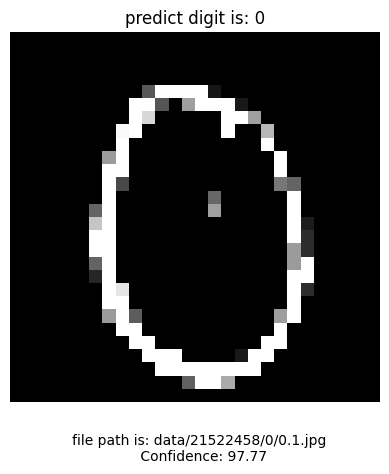

data/21522458/0/0.2.jpg
1/1 [==============================] - 0s 55ms/step
The model predicts the digit as: 6
Confidence: 0.646401


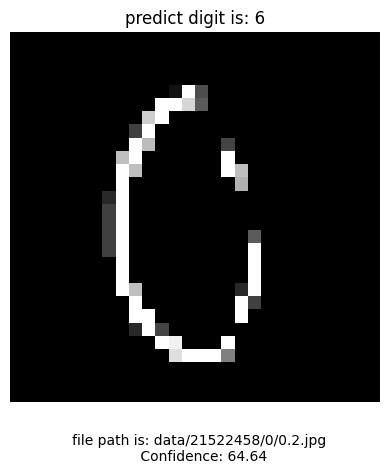

data/21522458/0/0.3.jpg
1/1 [==============================] - 0s 58ms/step
The model predicts the digit as: 0
Confidence: 0.9999734


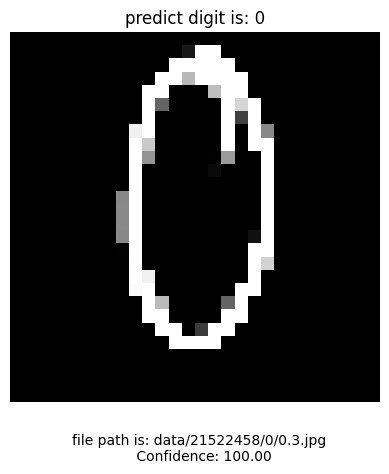

data/21522458/1/1.1.jpg
1/1 [==============================] - 0s 54ms/step
The model predicts the digit as: 1
Confidence: 0.9953028


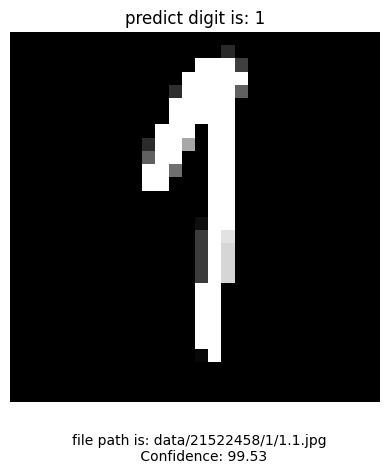

data/21522458/1/1.2.jpg
1/1 [==============================] - 0s 51ms/step
The model predicts the digit as: 1
Confidence: 0.99821717


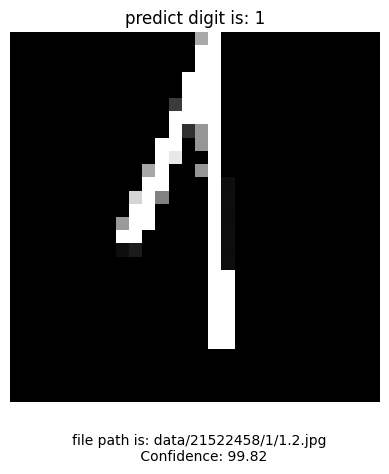

data/21522458/1/1.3.jpg
1/1 [==============================] - 0s 55ms/step
The model predicts the digit as: 1
Confidence: 0.99646014


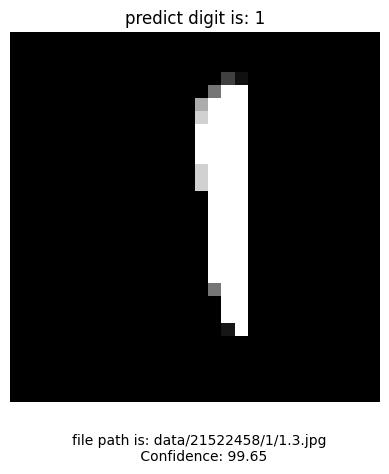

data/21522458/2/2.1.jpg
1/1 [==============================] - 0s 97ms/step
The model predicts the digit as: 3
Confidence: 0.51255614


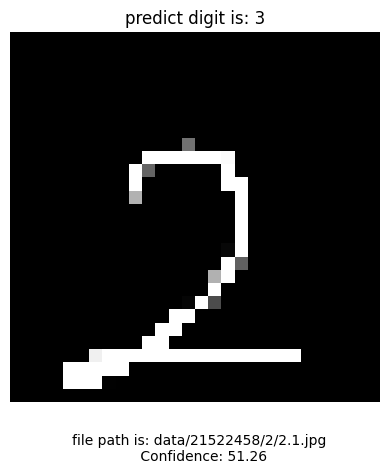

data/21522458/2/2.2.jpg
1/1 [==============================] - 0s 82ms/step
The model predicts the digit as: 2
Confidence: 0.8554446


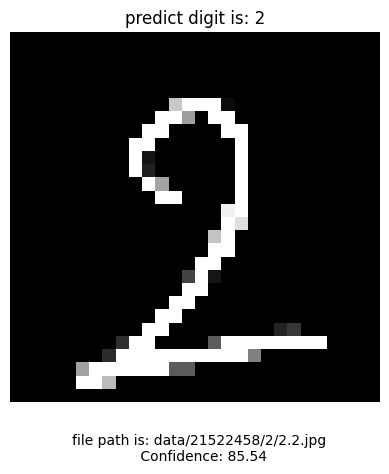

data/21522458/2/2.3.jpg
1/1 [==============================] - 0s 83ms/step
The model predicts the digit as: 2
Confidence: 1.0


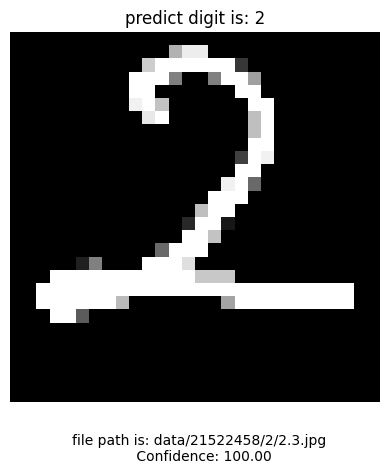

data/21522458/3/3.1.jpg
1/1 [==============================] - 0s 77ms/step
The model predicts the digit as: 3
Confidence: 1.0


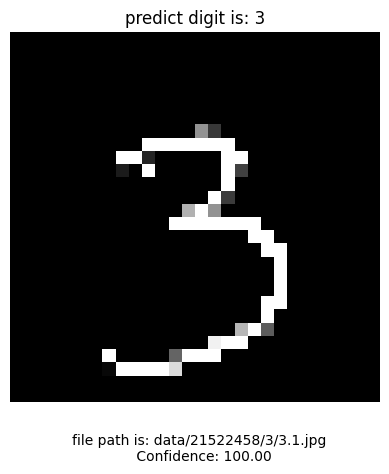

data/21522458/3/3.2.jpg
1/1 [==============================] - 0s 87ms/step
The model predicts the digit as: 3
Confidence: 1.0


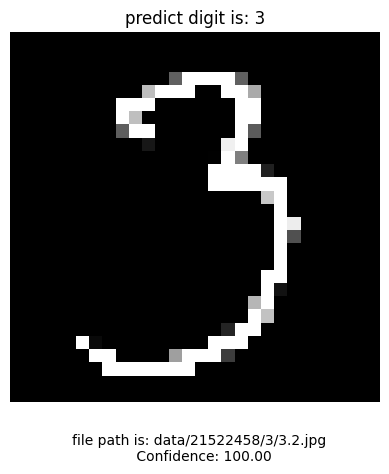

data/21522458/3/3.3.jpg
1/1 [==============================] - 0s 82ms/step
The model predicts the digit as: 1
Confidence: 0.9176643


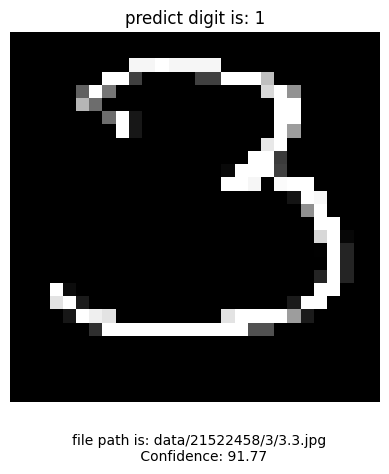

data/21522458/4/4.1.jpg
1/1 [==============================] - 0s 102ms/step
The model predicts the digit as: 4
Confidence: 0.9999999


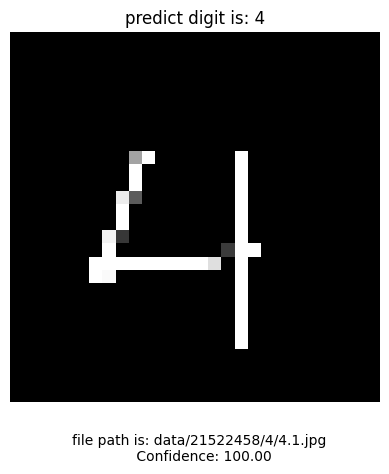

data/21522458/4/4.2.jpg
1/1 [==============================] - 0s 102ms/step
The model predicts the digit as: 4
Confidence: 0.99999976


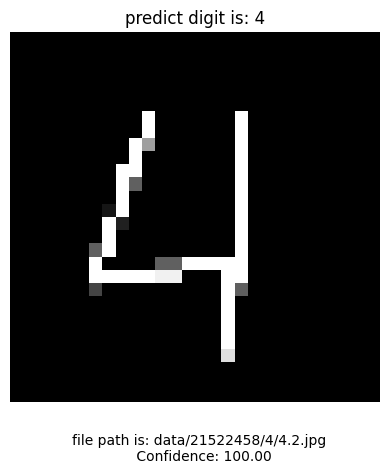

data/21522458/4/4.3.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 4
Confidence: 0.97219896


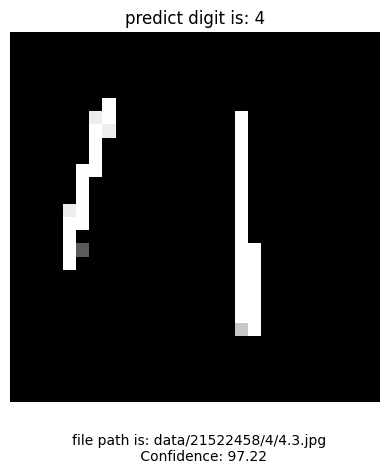

data/21522458/5/5.1.jpg
1/1 [==============================] - 0s 54ms/step
The model predicts the digit as: 7
Confidence: 0.7376426


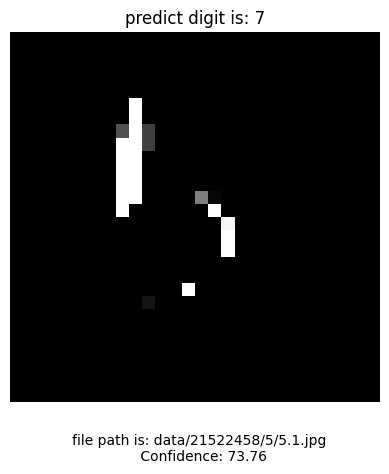

data/21522458/5/5.2.jpg
1/1 [==============================] - 0s 65ms/step
The model predicts the digit as: 5
Confidence: 0.99999034


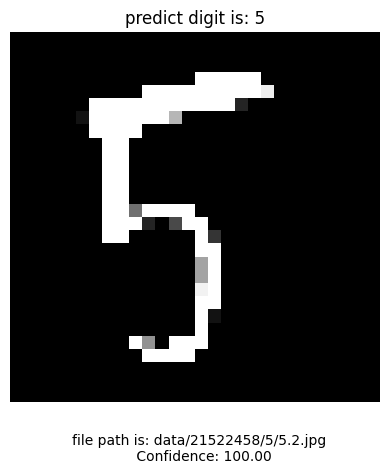

data/21522458/5/5.3.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 1
Confidence: 0.8087337


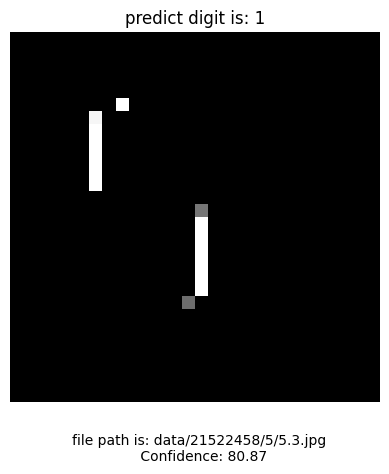

data/21522458/6/6.1.jpg
1/1 [==============================] - 0s 59ms/step
The model predicts the digit as: 6
Confidence: 0.8769489


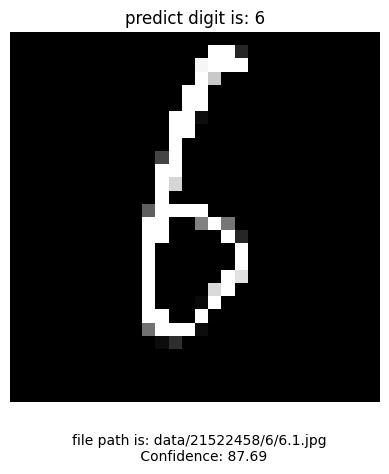

data/21522458/6/6.2.jpg
1/1 [==============================] - 0s 56ms/step
The model predicts the digit as: 8
Confidence: 0.86594397


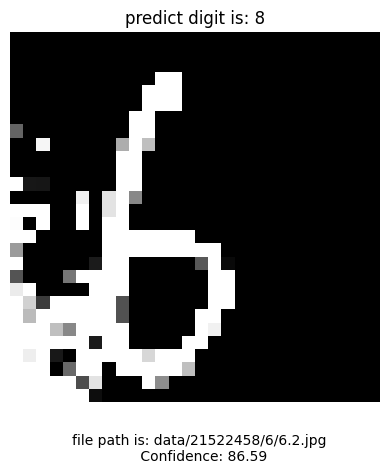

data/21522458/6/6.3.jpg
1/1 [==============================] - 0s 54ms/step
The model predicts the digit as: 6
Confidence: 0.5488179


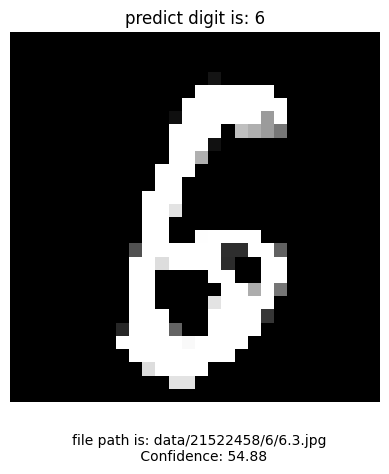

data/21522458/7/7.1.jpg
1/1 [==============================] - 0s 56ms/step
The model predicts the digit as: 1
Confidence: 0.8657999


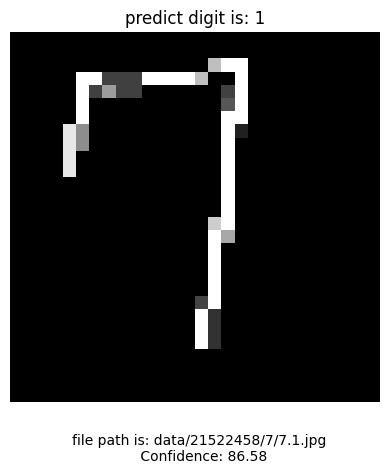

data/21522458/7/7.2.jpg
1/1 [==============================] - 0s 50ms/step
The model predicts the digit as: 1
Confidence: 0.9992944


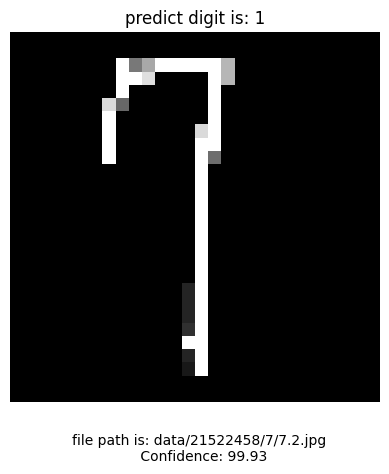

data/21522458/7/7.3.jpg
1/1 [==============================] - 0s 54ms/step
The model is not confident in its prediction.
Best fit: 7


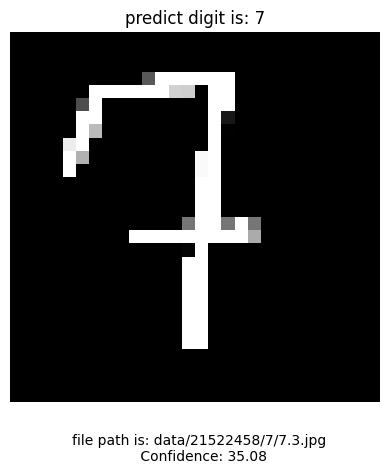

data/21522458/8/8.1.jpg
1/1 [==============================] - 0s 57ms/step
The model predicts the digit as: 8
Confidence: 0.99998605


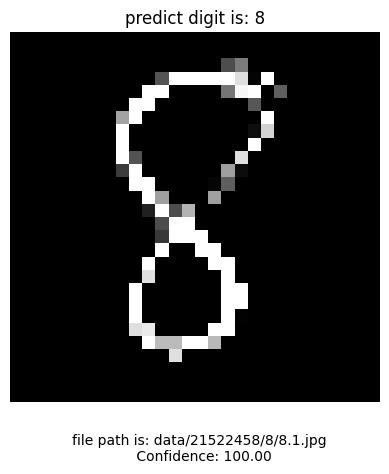

data/21522458/8/8.2.jpg
1/1 [==============================] - 0s 57ms/step
The model predicts the digit as: 8
Confidence: 0.9999602


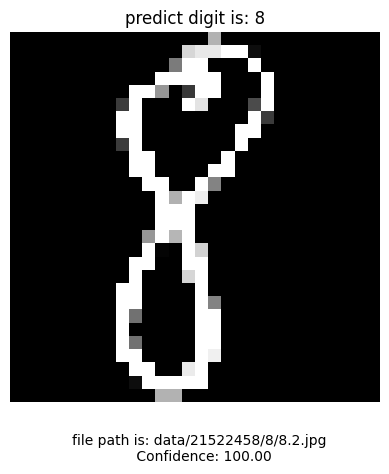

data/21522458/8/8.3.jpg
1/1 [==============================] - 0s 55ms/step
The model predicts the digit as: 8
Confidence: 1.0


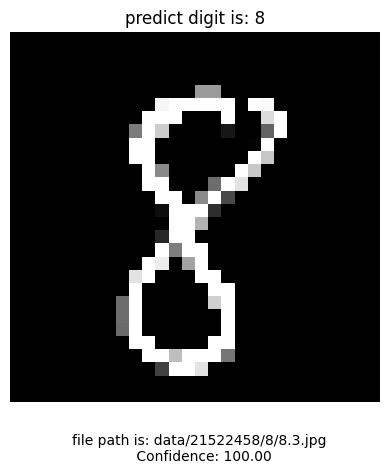

data/21522458/9/9.1.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 7
Confidence: 0.6405758


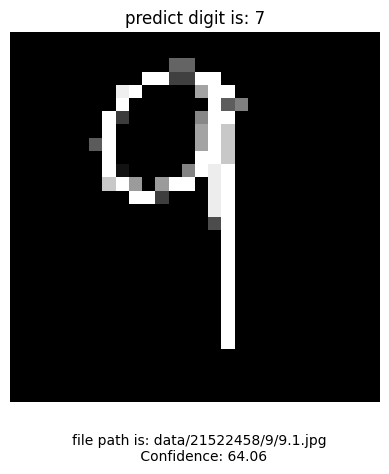

data/21522458/9/9.2.jpg
1/1 [==============================] - 0s 59ms/step
The model predicts the digit as: 7
Confidence: 0.55912703


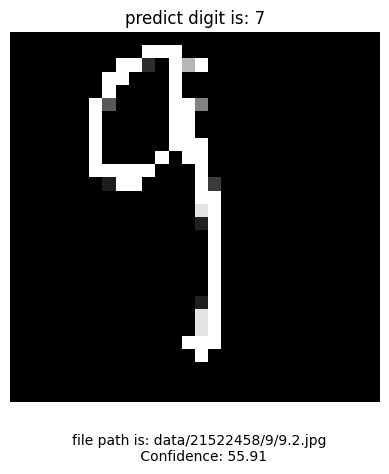

data/21522458/9/9.3.jpg
1/1 [==============================] - 0s 52ms/step
The model predicts the digit as: 7
Confidence: 0.8443485


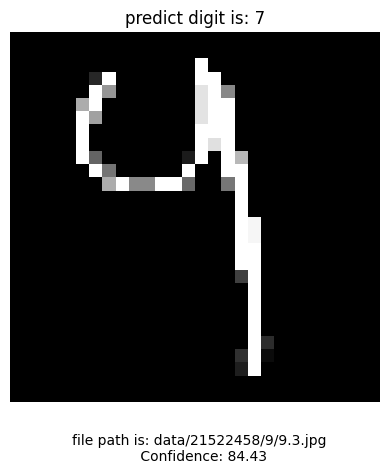

data/21522458_/0/0.1.jpg
1/1 [==============================] - 0s 56ms/step
The model predicts the digit as: 0
Confidence: 0.9999112


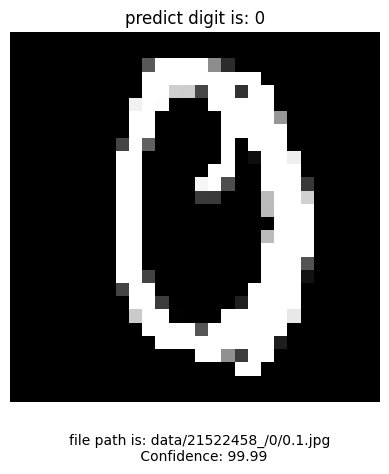

data/21522458_/0/0.2.jpg
1/1 [==============================] - 0s 56ms/step
The model predicts the digit as: 8
Confidence: 0.8065472


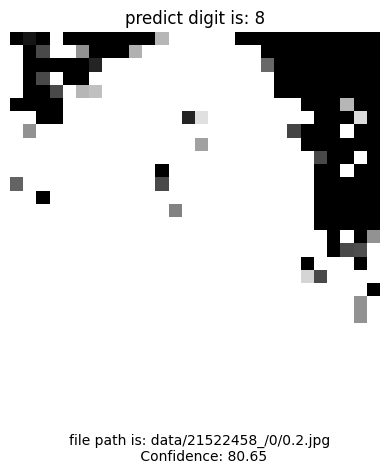

data/21522458_/0/0.3.jpg
1/1 [==============================] - 0s 50ms/step
The model predicts the digit as: 0
Confidence: 0.9997845


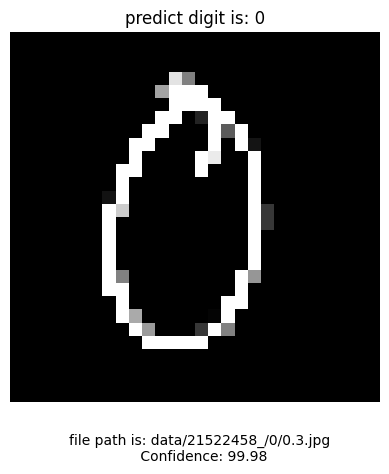

data/21522458_/1/1.1.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 6
Confidence: 0.82034767


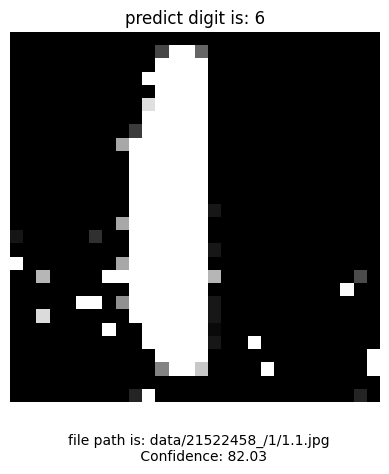

data/21522458_/1/1.2.jpg
1/1 [==============================] - 0s 58ms/step
The model predicts the digit as: 8
Confidence: 0.88315696


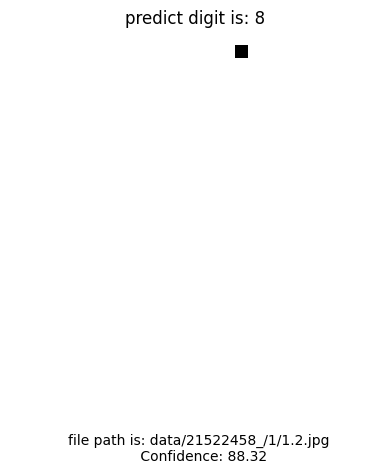

data/21522458_/1/1.3.jpg
1/1 [==============================] - 0s 66ms/step
The model predicts the digit as: 1
Confidence: 0.98251224


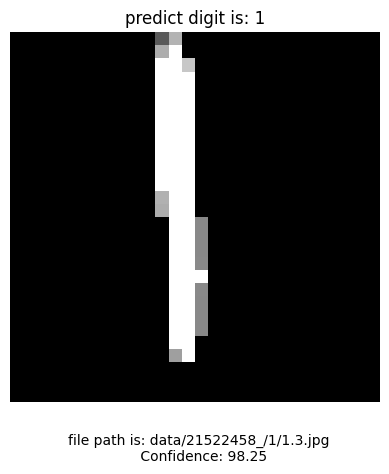

data/21522458_/2/2.1.jpg
1/1 [==============================] - 0s 60ms/step
The model predicts the digit as: 2
Confidence: 0.9999993


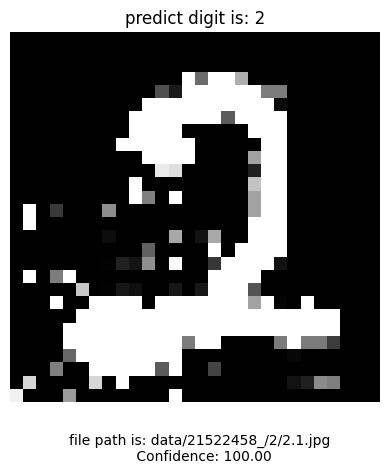

data/21522458_/2/2.2.jpg
1/1 [==============================] - 0s 55ms/step
The model predicts the digit as: 8
Confidence: 0.8740481


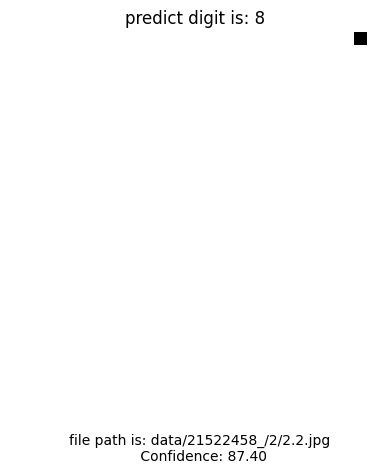

data/21522458_/2/2.3.jpg
1/1 [==============================] - 0s 56ms/step
The model predicts the digit as: 1
Confidence: 0.911284


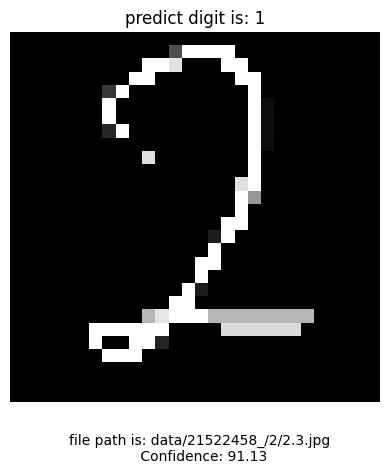

data/21522458_/3/3.1.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 3
Confidence: 0.9999999


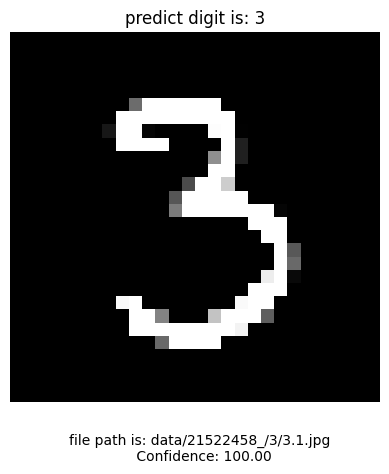

data/21522458_/3/3.2.jpg
1/1 [==============================] - 0s 55ms/step
The model predicts the digit as: 8
Confidence: 0.92878145


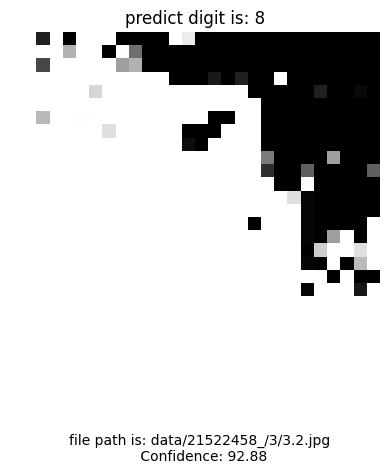

data/21522458_/3/3.3.jpg
1/1 [==============================] - 0s 56ms/step
The model predicts the digit as: 8
Confidence: 0.5512697


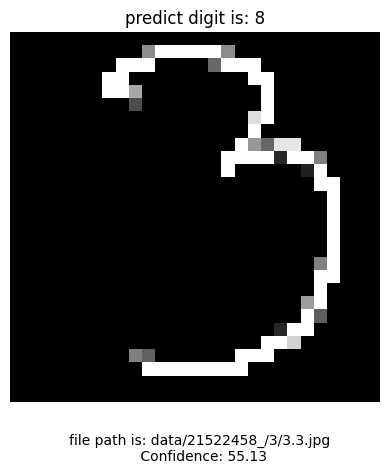

data/21522458_/4/4.1.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 4
Confidence: 1.0


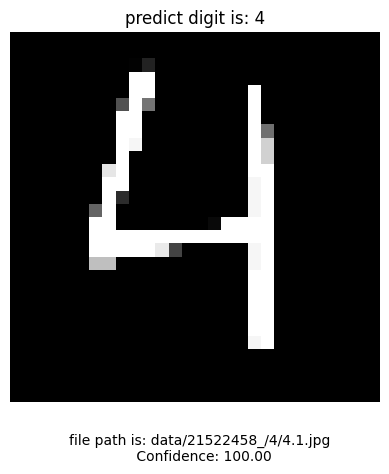

data/21522458_/4/4.2.jpg
1/1 [==============================] - 0s 90ms/step
The model predicts the digit as: 4
Confidence: 0.9564327


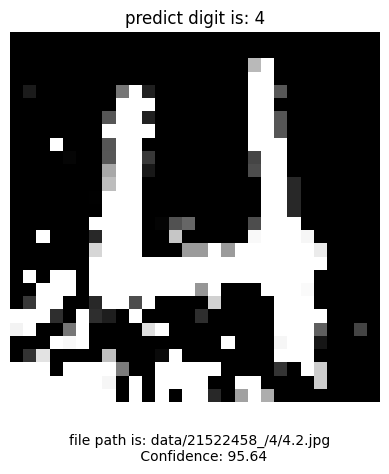

data/21522458_/4/4.3.jpg
1/1 [==============================] - 0s 81ms/step
The model predicts the digit as: 4
Confidence: 0.99999857


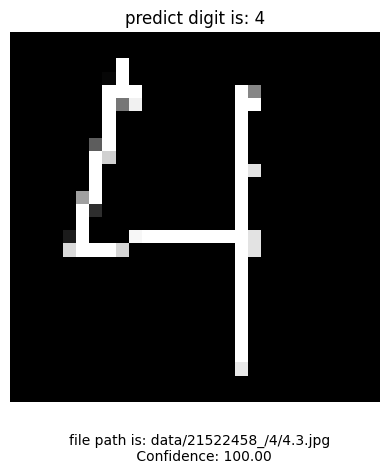

data/21522458_/5/5.1.jpg
1/1 [==============================] - 0s 82ms/step
The model is not confident in its prediction.
Best fit: 3


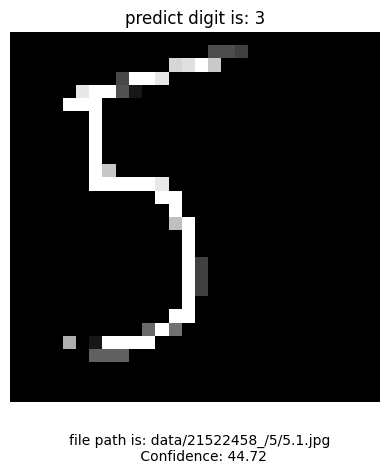

data/21522458_/5/5.2.jpg
1/1 [==============================] - 0s 96ms/step
The model predicts the digit as: 5
Confidence: 0.93342143


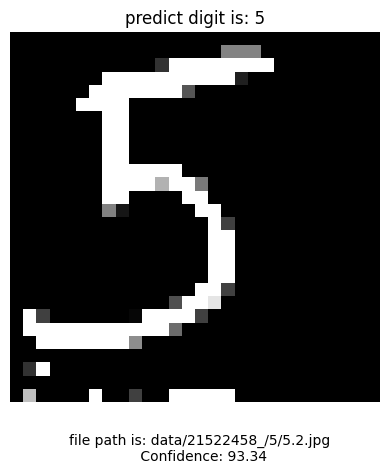

data/21522458_/5/5.3.jpg
1/1 [==============================] - 0s 81ms/step
The model predicts the digit as: 5
Confidence: 1.0


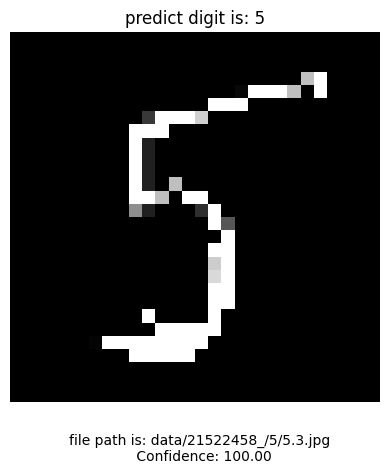

data/21522458_/6/6.1.jpg
1/1 [==============================] - 0s 99ms/step
The model predicts the digit as: 8
Confidence: 0.99950314


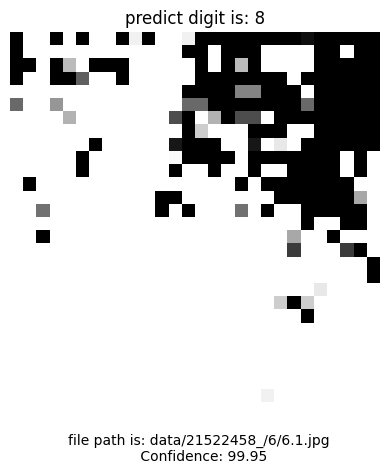

data/21522458_/6/6.2.jpg
1/1 [==============================] - 0s 93ms/step
The model predicts the digit as: 8
Confidence: 0.8803869


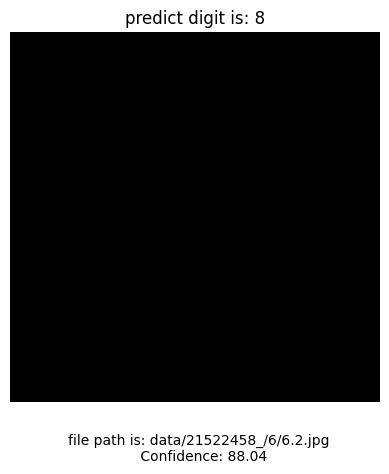

data/21522458_/6/6.3.jpg
1/1 [==============================] - 0s 102ms/step
The model is not confident in its prediction.
Best fit: 5


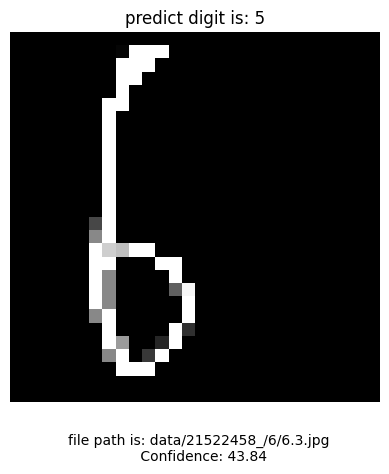

data/21522458_/7/7.1.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 8
Confidence: 0.83100414


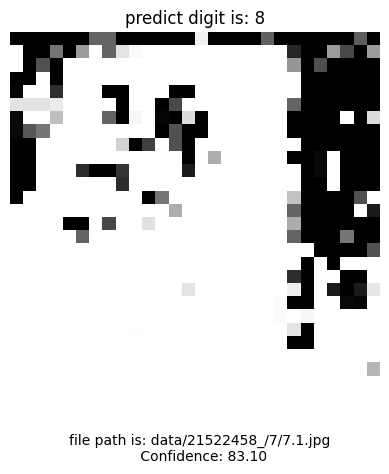

data/21522458_/7/7.2.jpg
1/1 [==============================] - 0s 55ms/step
The model predicts the digit as: 8
Confidence: 0.8803869


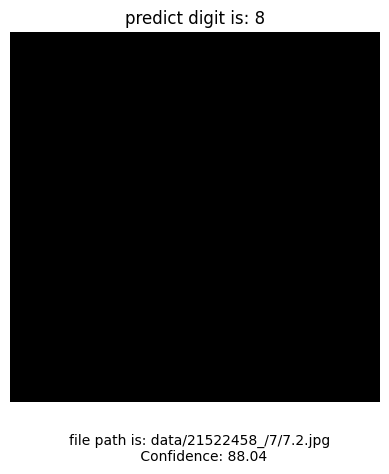

data/21522458_/7/7.3.jpg
1/1 [==============================] - 0s 55ms/step
The model predicts the digit as: 2
Confidence: 0.58426404


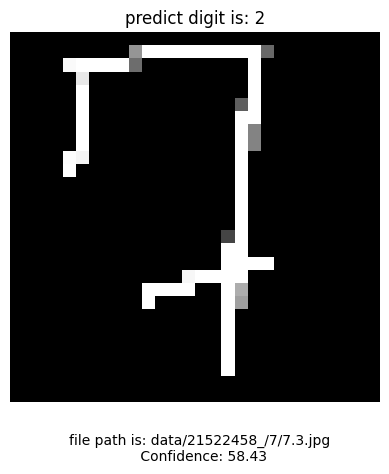

data/21522458_/8/8.1.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 8
Confidence: 0.9999999


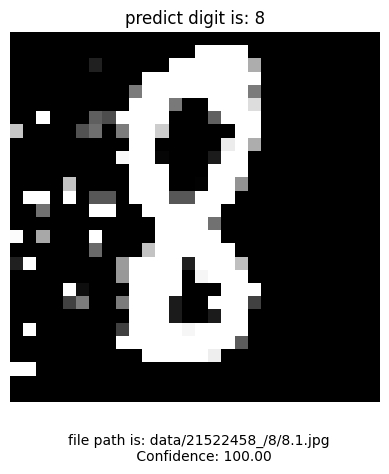

data/21522458_/8/8.2.jpg
1/1 [==============================] - 0s 55ms/step
The model predicts the digit as: 8
Confidence: 0.8803869


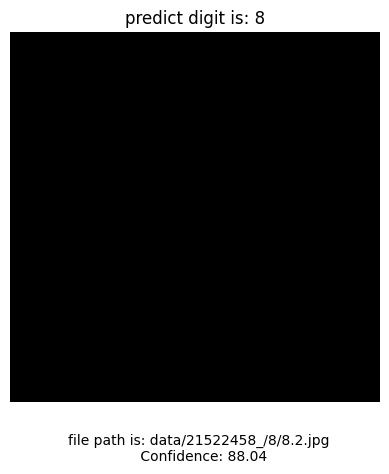

data/21522458_/8/8.3.jpg
1/1 [==============================] - 0s 60ms/step
The model predicts the digit as: 8
Confidence: 0.99999964


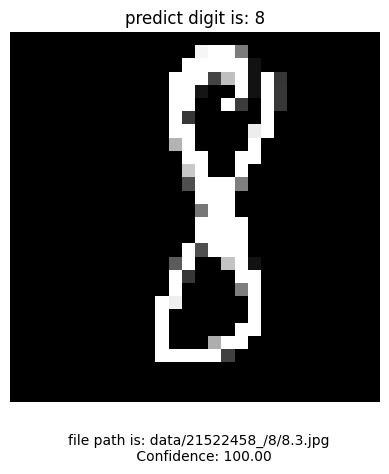

data/21522458_/9/9.1.jpg
1/1 [==============================] - 0s 51ms/step
The model predicts the digit as: 3
Confidence: 0.8062796


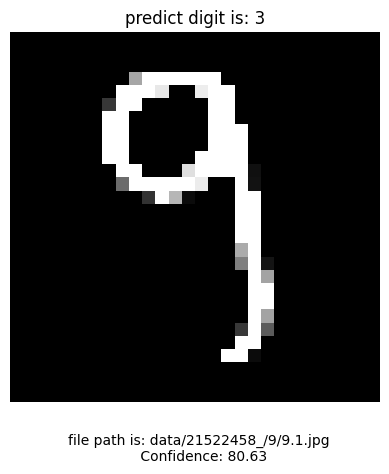

data/21522458_/9/9.2.jpg
1/1 [==============================] - 0s 53ms/step
The model predicts the digit as: 8
Confidence: 0.85724145


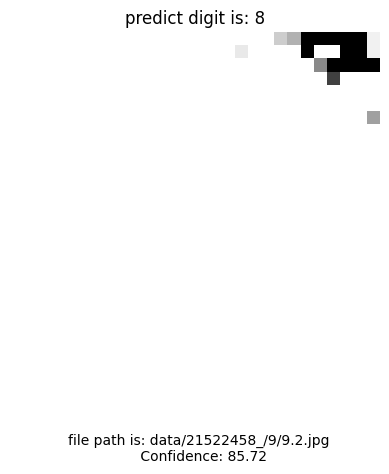

data/21522458_/9/9.3.jpg
1/1 [==============================] - 0s 56ms/step
The model predicts the digit as: 3
Confidence: 0.998218


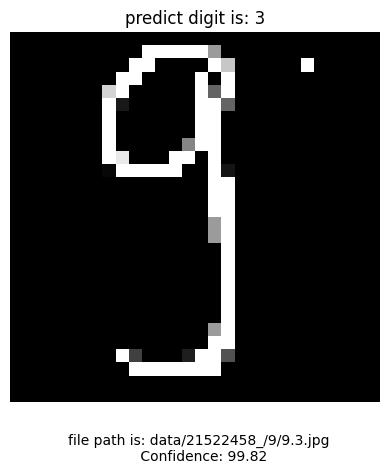

total images:60
correct predictions is: 32
accuracy is:$53.333333333333336% 


In [54]:
accuracy = run_example()



In [55]:
print(total_img)
arr = list(accuracy)
print(f'correct predictions:{arr[0]}')
print(f'accuracy:{arr[1]}')


60
correct predictions:32
accuracy:53.333333333333336


##Nhận xét:


---

```
    + Kết quả thay đổi dựa vào độ sáng của ảnh chụp
    + Kết quả thay đổi dựa vào góc chụp, và size ảnh (do khi resize sẽ ép về dạng 28x28)
    + Kết quả thay đổi dựa vào chữ viết, do kết quả train chỉ áp dụng cho 1 số hình nhất định
    +    Vd: 1 hình que thẳng đứng, 7 không có dấu gạch lưng, 9 không có nét cong ở dưới...
    + Kết quả thay đổi dựa vào màu nền, nếu dùng giấy ô ly, không đạt hiệu quả
```

---



Giải thích các hàm đã chỉnh sửa: Hàm run_example() và hàm load_image()

hàm load_image gồm có các parameter sau : (filename, alpha=0.85, beta=2, threshold=130, dilation_kernel_size=3)

trong đó:
+ file name là tên file
+ alpha là đối số của contrast (độ tương phản)
+ beta là giá trị tăng thử cho pixel, có thể xem là giá trị tạm để dùng cho "cv2.convertScaleAbs", đối số này khiến từng pixel tăng hoặc giảm 1 đơn vị
+ threshold là ngưỡng để mà quyết định tính nhị phân của pixel

trong hàm "load_img":
    +đã load opencv (cv2)
    +b1 đọc ảnh chuyển thành dạng trắng đen ( chỉ có 1 kênh màu k còn rgb)
    +b2 scale ảnh với alpha & beta: alpha là độ tương phản, beta = dộ tăng giảm pixel
    +b3 threshold cái ảnh: quyết định tính trắng đen của pixel dựa trên ngưỡng chọn là 130 (nghĩa là >130 sẽ là 0 (trắng), <= 130 là đen, do parameter 255 nghĩa là sẽ revert trằng -> đen, đen-> trắng)
    +b4 định nghĩa 1 kernel để giản nở: đã đặt cho "dilation_kernel_size=3", dãn phần trắng xung qua 3px
    +b5 resize - reshape lại cho đúng dạng (1,28,28,1): phần còn lại giữ nguyên

hàm run_example():

    +load ảnh lần lượt từ directory real_test1-> real_test6
    +ở mỗi folder sẽ load ảnh từ 0.jpg -> 9.jpg
    +kiểm tra ảnh có match với tên hay không (do tên đã đặt vậy để dễ check Kết quả)
    +Load ảnh, và confidence của mỗi ảnh để kiểm tra
    +Kết quả cuối cùng: accuracy đúng = 53.33%, đúng 32/60